# Part 1: Data Wrangling with Breeds on CPU

# Fetch Your Data
![Fetch Data](assets/part1_1.jpg)

# Part 1: Data Wrangling with Breeds on CPU

### Activity 
Click the cell below and then click **Run**.

In [1]:
import os
import tarfile

In [2]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import seaborn as sns
import dicom as dicom
import os
import glob
import pandas as pd
import scipy.ndimage
from skimage import measure, morphology
from sklearn.preprocessing import LabelEncoder
#import imgaug as ia
#from imgaug import augmenters as iaa
import random
from collections import Counter
%matplotlib inline

/home/u21744/.local/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


![View and Understand Your Data](assets/part1_2.jpg)

In [98]:
# Get Patient IDs
def getPatientIDs(path) :
    """
    Takes path to directory with patient folders and 
    returns a list of filenames representing each patient
    Input: string -- directory path
    Output: list  -- patient IDs
    """
    patients = os.listdir(path)
    patients = list(set(patients))
    return patients

path = '/home/u21744/TF_Slim_breeds/TCGA-BRCA'
patients = getPatientIDs(path)

In [99]:
path = '/home/u21744/TF_Slim_breeds/biospecimen.project-TCGA-BRCA.2018-11-04/slide.tsv'
label_cols = ['case_id','case_submitter_id']
id_match = pd.read_csv(path,sep='\t', na_values='NA',usecols=label_cols, engine='python' )
print(id_match.head())

                                case_id case_submitter_id
0  3144f1fb-4342-4079-bfe8-940da4bfd88e      TCGA-E2-A14V
1  4922cddc-575c-4b8a-8245-ce5f6876760c      TCGA-E9-A1R3
2  b0f8d698-a30e-4d8d-b0a2-a5a01fac8406      TCGA-A2-A0T4
3  b0f8d698-a30e-4d8d-b0a2-a5a01fac8406      TCGA-A2-A0T4
4  b0f8d698-a30e-4d8d-b0a2-a5a01fac8406      TCGA-A2-A0T4


In [101]:
# load patient data and labels (staging)

def getLabels(path,cols,patient_list) :
    """
    Takes path to txt file with patient IDs and labels, reads in
    selected columns, renames the columns, encodes the string labels as
    binary and returns the dataframe
    with matching patient IDs and labels.
    Input: 
        path - string - path to file
        cols - list - column names
    Output: 
        labels_brca - dataframe - IDs and labels
        patient_labels - list of labels
    """
    labels_brca = pd.read_csv(path,sep='\t', na_values='NA',usecols=cols, engine='python' )
    labels_brca.rename(index=str, columns={"case_id": "patients",
                                          'tumor_stage': 'stage'}, 
                       inplace=True)
    #labels_brca['patients'] = labels_brca['patients'].str.upper()
    # Convert Class labels to binary using Label Encoder
    encoder = LabelEncoder()
    encoder.fit(labels_brca["stage"])
    labels_brca['class'] = encoder.transform(labels_brca["stage"])
    labels_brca['y'] = labels_brca.apply (lambda row: label_stage (row),axis=1)
    #labels_brca = labels_brca.drop(['class2','class'],axis=1)
    patient_labels = []
    for patient in patient_list:
        label = labels_brca['y'][labels_brca['patients']==patient].values
        patient_labels.append(label)
    return labels_brca, patient_labels

def label_stage (row):
    if (row[1] == 'stage i') or (row[1] == 'stage ia') or (row[1] == 'stage ib'):
        return 0
    elif (row[1] == 'stage ii') or (row[1] == 'stage iia') or (row[1] == 'stage iib'):
        return 0
    elif (row[1] == 'stage iii') or (row[1] == 'stage iiia') or (row[1] == 'stage iiib') or (row[1] == 'stage iiic'):
        return 1
    elif (row[1] == 'stage iv') or (row[1] == 'stage x'):
        return 1
    else:
        return 1

path = '/home/u21744/TF_Slim_breeds/clinical.project-TCGA-BRCA.2018-11-04/clinical.tsv'
label_cols = ['case_id','tumor_stage'] # case_id, tumor_stage
labels_brca, patient_labels = getLabels(path,label_cols,patients)
print('Number of Unique patients with Imaging is {} out of {}'.format(len(patients), 
                                                                      len(labels_brca)) )
print(labels_brca['stage'].value_counts()) # Class imbalance
print(labels_brca.head())

Number of Unique patients with Imaging is 30 out of 1098
stage iia       358
stage iib       257
stage iiia      155
stage i          90
stage ia         86
stage iiic       65
stage iiib       27
stage iv         20
stage x          13
not reported     11
stage ib          7
stage ii          6
stage iii         2
--                1
Name: stage, dtype: int64
                               patients       stage  class  y
0  3144f1fb-4342-4079-bfe8-940da4bfd88e   stage iib      7  0
1  4922cddc-575c-4b8a-8245-ce5f6876760c  stage iiic     11  1
2  b0f8d698-a30e-4d8d-b0a2-a5a01fac8406   stage iia      6  0
3  2b36853f-34d3-47c5-ba6a-e5a93233d2b1   stage iib      7  0
4  8c7e74e0-71ef-49b8-9217-94b8ef740ef9   stage iib      7  0


In [102]:
# Resolve path to dcm files in stepwise manner due to complicated file structure
def getScans(path):
    """
    Takes path to patient directory, loops through subfolders
    to find each scan, its path, slice count and modality
    Input: string - path to patient directory
    Output:
        scan_paths - list of strings - paths to each scan
        slice_count - list of integers - number of slices in each scan
        Modality - list of strings - modality for each scan
    """
    scan_paths= []
    slice_count = []
    Modality = []
    for patient in os.listdir(path):
        patient_path = path + '/' + patient
        for folder in os.listdir(patient_path):
            patient_folder = patient_path + '/' + folder
            for each_scan in os.listdir(patient_folder):
                scan_path = patient_folder + '/' + each_scan
                scan_paths.append(scan_path)
                slice_count.append(len(os.listdir(scan_path)))
                Modality.append(dicom.read_file(scan_path  + '/' + os.listdir(scan_path)[0]).Modality)
    #scan_paths.sort()
    return scan_paths, slice_count, Modality

path = '/home/u21744/TF_Slim_breeds/TCGA-BRCA'
scan_paths, slice_count, Modality = getScans(path)
print('Total Number of Scans: {} for {} patients'.format(len(scan_paths),len(patients)))    

Total Number of Scans: 533 for 30 patients


In [103]:
def getScansMeta(path):
    """
    Takes path to patient directory, loops through subfolders
    to find each scan, its path, slice count and modality
    Input: string - path to patient directory
    Output:
        scan_paths - list of strings - paths to each scan
        slice_count - list of integers - number of slices in each scan
        Modality - list of strings - modality for each scan
    """
    scan_paths= []
    slice_count = []
    Modality = []
    scan_dims = []
    for root, dirs, files in os.walk(path):
        if len(files) > 0:
            if files[0].endswith('.dcm'):
                #print(root)
                scan_paths.append(root)
                slice_count.append(len(files))
                slices = dicom.read_file(os.path.join(root,files[0]))
                #print(slices)
                Modality.append(slices.Modality)
                scan_dims =  slices.pixel_array.shape
    return scan_paths, slice_count, Modality

path = '/home/u21744/TF_Slim_breeds/TCGA-BRCA'
scan_paths, slice_count, Modality = getScansMeta(path)
print('Total Number of Scans: {} for {} patients'.format(len(scan_paths),len(patients))) 

Total Number of Scans: 533 for 30 patients


/home/u21744/TF_Slim_breeds/TCGA-BRCA/TCGA-AO-A0J9/05-11-2001-96851/100-Bind1547751..61-72307/000047.dcm


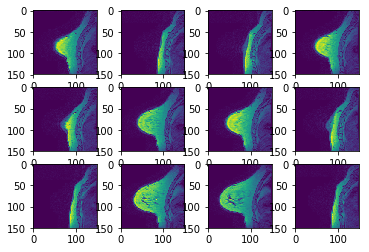

/home/u21744/TF_Slim_breeds/TCGA-BRCA/TCGA-AO-A0J9/05-11-2001-96851/117-PJN-66190/000009.dcm


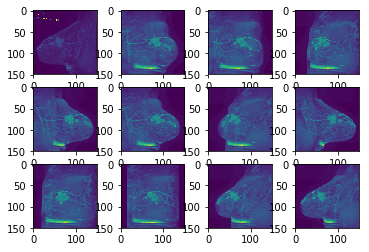

/home/u21744/TF_Slim_breeds/TCGA-BRCA/TCGA-AO-A0J9/05-11-2001-96851/1-Localization-18424/000018.dcm


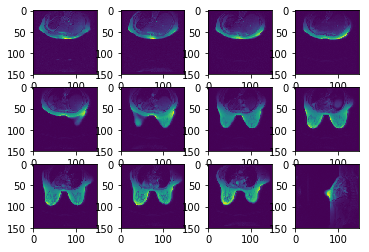

/home/u21744/TF_Slim_breeds/TCGA-BRCA/TCGA-AO-A0J9/05-11-2001-96851/102-Bind1547761..61-71228/000047.dcm


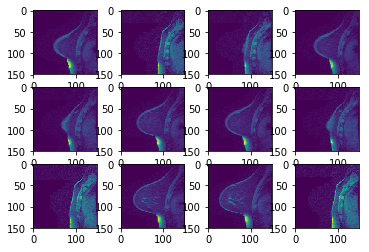

/home/u21744/TF_Slim_breeds/TCGA-BRCA/TCGA-AO-A0J9/05-11-2001-96851/3-T2 right breast-90643/000047.dcm


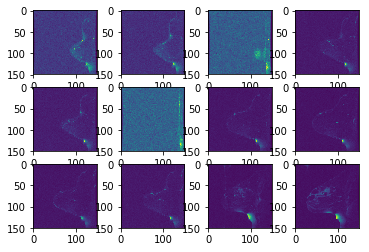

In [45]:
def exploreScans(path, IMG_PX_SIZE = 150):
    """
    Plots/Displays 12 slices of each scan for patients 
    in patient_list at the specified size (IMG_PX_SIZE)
    Input: 
        path - string - path to patient directories
        patients_list - list of strings - selected patient IDs
        IMG_PX_SIZE - integer - output image length in pixels
    Output: plot
    """
    for scan in path:
        dcm_files = os.listdir(scan)
        slices = [dicom.read_file(scan + '/' + file) for file in dcm_files
                 if (dicom.read_file(scan + '/' + file)).Modality =='MR'] # read only MRIs
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        # plot
        fig = plt.figure()
        for num, each_slice in enumerate(slices[:12]):
            y = fig.add_subplot(3,4,num+1)
            new_image = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
            y.imshow(new_image)
        plt.show()
    return
        
scan_n = scan_paths[:5]
exploreScans(scan_n)

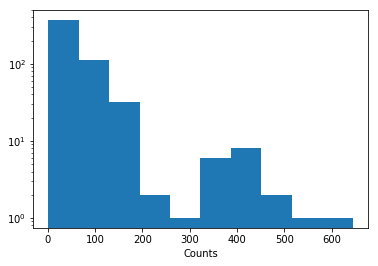

In [104]:
# Visualize number of slices in each scan
plt.hist(slice_count)
plt.xlabel('Number of slices')
plt.xlabel('Counts')
plt.yscale('log')
plt.show()

In [105]:
from statistics import median, mode
print('Maximum number of slices in a scan is: ', max(slice_count))
print('Minimum number of slices in a scan is: ', min(slice_count))
print('Median number of slices in a scan is: ', median(slice_count))
#print('Modal number of slices in a scan is: ', mode(slice_count))

Maximum number of slices in a scan is:  644
Minimum number of slices in a scan is:  1
Median number of slices in a scan is:  51


In [106]:
# Count number of scan modalities in dataset
Counter(Modality)

Counter({'MG': 10, 'MR': 523})


![Clean and Normalize the Data](assets/part1_3.jpg)

In [107]:
# Resize images and apply constraints on scan type and number of slices
# Normalize number of slices per scan

from time import time

#data_dir = 'C:\TCIA-BRCA\DOI'
data_dir = '/home/u21744/TF_Slim_breeds/TCGA-BRCA'

IMG_PX_SIZE = 50
HM_SLICES = 20

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    l - list of lists - slices
    n - integer - chunk sizes
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    """
    Returns average of pixel values at each stacked position in chunk
    l - list of lists - slices, pixel array as list
    """
    return sum(l)/len(l)
        
def process_data(scan_path, labels_brca, img_px_size=50, hm_slices=20, visualize=False):
    """
    Takes scan path and labels, reads dicom file if Modality is MRI and number of slices > 20,
    sorts slices for each scan by position, gets Patient ID and label from scan,
    Resizes each slice using openCV. Since number of slices per scan is not uniform,
    Takes series of steps to return uniform number of slices per scan by
    1. Dividing each slice into 20 chunks of "equal" size (len(slices)/hm_slices) plus remainder
    2. converts each chunk to a slice by finding the mean of all stacked positions in one chunk
    3. removes or appends last slices in each chunk to make chunks uniform (20 slices)
    """
    slices = [dicom.read_file(scan_path + '/' + slice_n) for slice_n in os.listdir(scan_path)]
    if (slices[0].Modality=='MR' and len(slices)>=20) :
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        patient = slices[0].PatientID
        #print(patient)
        pid = id_match['case_id'][id_match['case_submitter_id']==patient].values[0]
        #print(pid)
        # case_id case_submitter_id
        label = labels_brca['y'][labels_brca['patients']==pid].values
        #print(label)
        
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]

        chunk_sizes = int(round(len(slices)/hm_slices)) # rounding??
        # rounding presents a huge challenge because scans will be divided unequally
        # e.g round(63/20) = 3.15 = 3, yields 63/3= 21 chunks of 3 slices each leading to
        # inconsistent number of chunks. Since each chunk will be reduced to make a slice
        # the new slices will have unequal number of slices

        for slice_chunk in chunks(slices,chunk_sizes):
            # for each chunk, zip yields each pixel array position for all slices,
            # mean gets the average of pixel values at each pixel_array position for all slices in that chunk
            # list returns a new slice as list of all pixel position means
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)
        
        # Some chunks are not 20 slices thick, some more, some less
        # for non-HM_SLICES chunks, removes or appends last slices in each chunk 
        # to make chunks uniform (20 slices)
        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            
        if len(new_slices) == HM_SLICES-3:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val
        
        if len(new_slices) == HM_SLICES+3:
            del new_slices[HM_SLICES:]
        
        if len(new_slices) == HM_SLICES+4:
            del new_slices[HM_SLICES:]
            
        if len(new_slices) == HM_SLICES+5:
            del new_slices[HM_SLICES:]

        if visualize:
            fig = plt.figure()
            for num, each_slice in enumerate(new_slices):
                y = fig.add_subplot(4,5,num+1)
                y.imshow(each_slice, cmap='gray')
                plt.show()
        
        # one-hot encoding for labels
        if label==1: # pos
            label = np.array([0,1])
        elif label==0: # neg
            label = np.array([1,0])

        return np.array(new_slices), label, patient

    else :
        label = 0
        patient = ''
        return np.empty([1,1]), label , patient

much_data_patient = [] # all patients  
pos_data_patients = [] # patients with late stage cancers
neg_data_patients = [] # negative pts, early cancers
t0 = time()

for num, scan_path in enumerate(scan_paths):
    if num%100==0:
        print (num)
        
    try:
        img_data, label, patient = process_data(scan_path, labels_brca, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        if img_data.shape == (20, 50, 50):
            much_data_patient.append([img_data, label, patient])
            if label[0]==0: # positive class -- late stage cancers
                pos_data_patients.append([img_data, label, patient])
            else : # negative class -- early stage cancers
                neg_data_patients.append([img_data, label, patient])
    except KeyError as e:
        print ('unlabeled')

print('Elapsed time: ', time()-t0)
print ('All Scans: {}\nPositive Scans: {} \nNegative Scans: {}'.format(len(much_data_patient),
                                                                      len(pos_data_patients),
                                                                      len(neg_data_patients)))



0
100
200
300
400
500
Elapsed time:  141.23436832427979
All Scans: 449
Positive Scans: 110 
Negative Scans: 339


In [108]:
print(len(much_data_patient)) # 449
print(len(pos_data_patients)) # 110
print(len(neg_data_patients)) # 339

449
110
339


In [109]:
# save preprocessed files to disk
np.save('muchdata-patient-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data_patient)

In [110]:
# save positive images
np.save('pos-patients-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), pos_data_patients)

In [111]:
# save positive images
np.save('neg-patients-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), neg_data_patients)

In [113]:
all_patients = np.load('muchdata-patient-50-50-20.npy')

In [114]:
patient_list = [image[2] for image in all_patients] 
patient_labels = [image[1] for image in all_patients]
patient_data = [image[0] for image in all_patients] 

In [119]:
len(patient_list)

449

In [115]:
patient_list[:5]

['TCGA-AO-A0J9',
 'TCGA-AO-A0J9',
 'TCGA-AO-A0J9',
 'TCGA-AO-A0J9',
 'TCGA-AO-A0J9']

In [124]:
from sklearn.model_selection import train_test_split

def splitIDs(data, labels, test_size, random_state) :
    """
    Wrapper for sklearn train_test_split function that splits a dataset into
    train and test sets using the test_size parameter
    Input: 
        data -- Patient IDs
        labels -- labels
        test_size -- proportion of data assigned to test set
        random_state -- random seed
    Output: train, validation and test set Arrays
    """
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                        test_size=test_size, 
                                                        random_state=random_state,
                                                       stratify = labels)
    # Shapes and Value counts
    #print('Training set shape: ', X_train.shape)
    print('Training set shape: ', len(X_train))
    print('\nTest set shape: ',len(X_test))#.shape)
    print('\nTraining set labels shape: ',len(y_train))#.shape)
    print('\nTest set labels shape: ',len(y_test))#.shape)
    #print('\nTraining set value counts: ',y_train.value_counts())
    #print('\nTest set value counts: ',y_test.value_counts())
    return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_true = splitIDs(patient_list, patient_labels, test_size=0.3, random_state=54)

Training set shape:  314

Test set shape:  135

Training set labels shape:  314

Test set labels shape:  135


In [ ]:
print(Counter(patient_labels))
print(Counter(y_train))
print(Counter(y_test))

![Organize Data for Consumption by Framework](assets/part1_4.jpg)

In [126]:
def normalizeSplit(img_data):
    """
    Takes dataset, mean and standard deviation of array
    Normalizes the arrays and assigns each image to the
    train/validation set based on Patient ID from train_test_split step above
    """
    validation_set=[]
    train_set=[]
    #print(img_data[0])
    for num, elem in enumerate(img_data):
        img = elem[0]
        # normalize
        if elem[2] in X_test:
            train_set.append([np.array(img),np.array(elem[1])])
        else:
            validation_set.append([np.array(img),np.array(elem[1])])
        if num%200==0:
            print (num, 'Done!')
    train_set = np.asarray(train_set)
    validation_set = np.asarray(validation_set)
    train_set /= 255.0
    validation_set /= 255.0
    return train_set, validation_set

            
train_set, validation_set = normalizeSplit(all_patients)
print(len(validation_set), len(train_set))

0 Done!
200 Done!
400 Done!
9 440


In [127]:
# save training and validation sets to disk
np.save('validation-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), validation_set)
np.save('train-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), train_set)

![Optimize Data for Ingestion](assets/part1_6.jpg)

In [3]:
train_data = np.load('train-50-50-20.npy')
validation_data = np.load('validation-50-50-20.npy')
print(train_data.shape)

(440, 2)


In [4]:
# extract labels for validation set
y_true = [i[1].tolist() for i in validation_data] # convert labels from array to lists
y_true = [0 if i == [1,0] else 1 for i in y_true] # convert from lists to binary
print(y_true[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
import tensorflow as tf
from time import time

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.7

In [6]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [7]:
def convolutional_neural_network(x):
    #                # 3 x 3 x 3 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       3 x 3 x 3 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  128 features
               'W_conv3':tf.Variable(tf.random_normal([3,3,3,64,128])),
               #                                  1024 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
              'b_conv3':tf.Variable(tf.random_normal([128])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)
    
    conv3 = tf.nn.relu(conv3d(conv2, weights['W_conv3']) + biases['b_conv3'])
    conv3 = maxpool3d(conv3)  
    
    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [8]:
import time
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    saver = tf.train.Saver()
    
    hm_epochs = 5
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        successful_runs = 0
        total_runs = 0
        t0=time.time()
        print('start time: ', t0)
        for epoch in range(hm_epochs):
            t0_epoch=time.time()
            #print(t0_epoch)
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
           
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
            print ('Epoch', epoch+1, "training time:", round(time.time()-t0_epoch, 3), "s") # the time would be round to 3 decimal in seconds
            t1=time.time()

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            print ('Epoch', epoch+1, "predict time:", round(time.time()-t1, 3), "s")
        
        print('Done! Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        prediction_out = sess.run(prediction, feed_dict={x: [i[0] for i in validation_data]})

        # predicted labels
        classification = sess.run(tf.argmax(prediction, 1), feed_dict={x: [i[0] for i in validation_data]})
        print(classification)
        
        classification2 = prediction.eval({x: [i[0] for i in validation_data]})
        
        print ("Total time:", round(time.time()-t0, 3), "s")
        
        # save model
        # data_dir = '/home/u21744/TF_Slim_breeds/TCGA-BRCA'
        saver.save(sess, 'home/u21744/TF_Slim_Breeds/tf_model/brca-tf-cnn-model_1.ckpt')
        print('fitment percent:',successful_runs/total_runs)
        return prediction, prediction_out, classification, classification2

# Run this locally:
prediction, prediction_out, classification, classification2 = train_neural_network(x)

start time:  1541367187.6570346
Epoch 1 completed out of 5 loss: 286456063.711
Epoch 1 training time: 439.622 s
Accuracy: 0.777778
Epoch 1 predict time: 0.378 s
Epoch 2 completed out of 5 loss: 5082443200.82
Epoch 2 training time: 439.18 s
Accuracy: 0.333333
Epoch 2 predict time: 0.355 s
Epoch 3 completed out of 5 loss: 31976198814.2
Epoch 3 training time: 440.792 s
Accuracy: 0.555556
Epoch 3 predict time: 0.381 s
Epoch 4 completed out of 5 loss: 77290953258.0
Epoch 4 training time: 438.774 s
Accuracy: 0.555556
Epoch 4 predict time: 0.351 s
Epoch 5 completed out of 5 loss: 183834520503.0
Epoch 5 training time: 439.142 s
Accuracy: 0.222222
Epoch 5 predict time: 0.384 s
Done! Finishing accuracy:
Accuracy: 0.555556
[1 1 1 1 1 0 0 1 1]
Total time: 2200.884 s


ValueError: Parent directory of home/u21744/TF_Slim_Breeds/tf_model/brca-tf-cnn-model_1.ckpt doesn't exist, can't save.

![Export Inference Graph](assets/part3_2.jpg)

In [ ]:
# restore saved model and evaluate

def TensorflowPredict(model_path, model_filename):
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph(model_path + model_filename)
        new_saver.restore(sess, tf.train.latest_checkpoint(model_path))
        y_pred = sess.run(tf.argmax(prediction, 1), feed_dict={x: [i[0] for i in validation_data]})
        return y_pred


path = 'home/u21744/TF_Slim_breeds/TCGA-BRCA/'
filename = 'brca-tf-cnn-model_1.ckpt.meta'
y_pred = TensorflowPredict(path, filename)
print (y_pred)

In [ ]:
from sklearn import metrics 

def TensorflowModelEval(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
    
    fpr, tpr, tresholds = metrics.roc_curve(y_true, y_pred)
    print('AUC', metrics.auc(fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(-0.05,1)
    plt.ylim(0,1.05)
    plt.show()
    
    print ('Accuracy', metrics.accuracy_score(y_true, y_pred))
    print ("Precision", metrics.precision_score(y_true, y_pred))
    print ("Recall", metrics.recall_score(y_true, y_pred))
    print ("f1_score", metrics.f1_score(y_true, y_pred))
    print ("confusion_matrix")
    print (metrics.confusion_matrix(y_true, y_pred))

In [ ]:
print (TensorflowModelEval(y_true, classification))

![Confirm Folder Structure is Correct](assets/part1_5.jpg)

![Modify Repo Scripts](assets/part2_3.jpg)

![Optimize Performance for CPU](assets/part2_4.jpg)

### Activity
In the cell below, update **OMP_NUM_THREADS** to **"12"**, **KMP_BLOCKTIME** to **"1"**, and then click **Run**.

In [ ]:
import os
import tensorflow as tf

os.environ["KMP_BLOCKTIME"] = ?
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["OMP_NUM_THREADS"] = ??
print("Done.")

### Fine-Tuning a Model from an Existing Checkpoint

"Rather than training from scratch, we'll often want to start from a pre-trained model and fine-tune it. To indicate a checkpoint from which to fine-tune, we'll call training with the --checkpoint_path flag and assign it an absolute path to a checkpoint file.

When fine-tuning a model, we need to be careful about restoring checkpoint weights. In particular, when we fine-tune a model on a new task with a different number of output labels, we wont be able restore the final logits (classifier) layer. For this, we'll use the --checkpoint_exclude_scopes flag. This flag hinders certain variables from being loaded. When fine-tuning on a classification task using a different number of classes than the trained model, the new model will have a final 'logits' layer whose dimensions differ from the pre-trained model. For example, if fine-tuning an ImageNet-trained model on Flowers, the pre-trained logits layer will have dimensions [2048 x 1001] but our new logits layer will have dimensions [2048 x 5]. Consequently, this flag indicates to TF-Slim to avoid loading these weights from the checkpoint.

Keep in mind that warm-starting from a checkpoint affects the model's weights only during the initialization of the model. Once a model has started training, a new checkpoint will be created in --train_dir. If the fine-tuning training is stopped and restarted, this new checkpoint will be the one from which weights are restored and not the --checkpoint_path. Consequently, the flags --checkpoint_path and --checkpoint_exclude_scopes are only used during the 0-th global step (model initialization). Typically for fine-tuning one only want train a sub-set of layers, so the flag --trainable_scopes allows to specify which subsets of layers should trained, the rest would remain frozen." See https://github.com/tensorflow/models/tree/master/research/slim#fine-tuning-a-model-from-an-existing-checkpoint.

![Fine-Tune a Model](assets/part2_5.jpg)

### Activity
In the cell below, update the **max_number_of_steps** parameter to a number between **500** and **1500**, the **intra_op** parameter to the number **12** and then click **Run**.

In [ ]:
!rm -rf train_dir
!mkdir train_dir

!python models/research/slim/train_image_classifier.py \
    --train_dir=train_dir \
    --dataset_name=breeds \
    --dataset_split_name=train \
    --clone_on_cpu=true \
    --dataset_dir=breeds \
    --model_name=inception_v1 \
    --checkpoint_path=checkpoints/inception_v1.ckpt \
    --checkpoint_exclude_scopes=InceptionV1/Logits \
    --trainable_scopes=InceptionV1/Logits \
    --max_number_of_steps=???? \
    --learning_rate=0.01 \
    --batch_size=32 \
    --save_interval_secs=60 \
    --save_summaries_secs=60 \
    --inter_op=2 \
    --intra_op=??

!echo "Done."

# Part 3: Evaluate, Freeze and Test Your Training Results

### Evaluate Your Latest Training Checkpoint

Earlier we created a TFRecord file with our validation images.  Below, we'll be using our validation set to determine our accuracy by running the eval_image_classifier script.  It will give us the Accuracy and Recall for Top 5.

![Evaluate Your Checkpoint](assets/part3_1.jpg)

### Activity
Click the cell below and then click **Run**.

In [ ]:
!rm -rf eval_dir
!mkdir eval_dir
!python models/research/slim/eval_image_classifier.py \
    --checkpoint_path=$(ls -t train_dir/model.ckpt* | head -1 | rev | cut -d '.' -f2- | rev) \
    --eval_dir=eval_dir \
    --dataset_dir=breeds \
    --dataset_name=breeds \
    --dataset_split_name=validation \
    --model_name=inception_v1

!echo "Done."    

### Export Your Inference Graph of Inception v1

We want to export our inference graph of Inception v1 so we can use it later to create a frozen graph (.pb) file.  Below, we'll run the export_inference_graph script that will take the inceptionv1 model and our dataset to create a .pb file.  Passing in our dataset is important since it will make sure to create a final layer of 37 categories rather than the 1000 from ImageNet.

### Activity
Click the cell below and then click **Run**.

In [ ]:
!python models/research/slim/export_inference_graph.py \
    --alsologtostderr \
    --model_name=inception_v1 \
    --image_size=224 \
    --batch_size=1 \
    --output_file=train_dir/inception_v1_inf_graph.pb \
    --dataset_name=breeds
    
!echo "Done."    

### Clone the Main TensorfFow Repo

We're cloning the main TensorFlow/TensorFlow repository since it contains the script to create a frozen graph.

![Clone TensorFlow Repo](assets/part3_3.jpg)

### Activity
Click the cell below and then click **Run**.

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/tensorflow.git
    
!echo "Done."    

### Freeze Your Graph

Freezing your graph will take the inference graph definition we created above and the latest checkpoint file that was created during training.  It will merge these two into a single file for a convenient way to have the graph definition and weights for deployment.

![Freeze Your Graph](assets/part3_4.jpg)

### Activity
Click the cell below and then click **Run**.

In [ ]:
!python tensorflow/tensorflow/python/tools/freeze_graph.py \
    --clear_devices=true \
    --input_graph=train_dir/inception_v1_inf_graph.pb \
    --input_checkpoint=$(ls -t train_dir/model.ckpt* | head -1 | rev | cut -d '.' -f2- | rev) \
    --input_binary=true \
    --output_graph=train_dir/frozen_inception_v1.pb \
    --output_node_names=InceptionV1/Logits/Predictions/Reshape_1
    
!echo "Done."    

### Look at a Sample Image

We're going to use this image to run through the network and see the results.

![Display a Sample Image](assets/part3_5.jpg)

### Activity
Click the cell below and then click **Run**.

In [ ]:
from PIL import Image

Image.open('breeds/train/maine_coon/Maine_Coon_100.jpg')

### Inference on an Image

We can use the newly created frozen graph file to test a sample image.  We're using the label_image script that takes an image, frozen graph, labels.txt files, and displays the top five probabilities for the given image.

![Inference on Image](assets/part3_6.jpg)

### Activity
Click the cell below and then click **Run**.

In [ ]:
!python tensorflow/tensorflow/examples/label_image/label_image.py \
    --image=breeds/train/maine_coon/Maine_Coon_100.jpg \
    --input_layer=input \
    --input_height=224 \
    --input_width=224 \
    --output_layer=InceptionV1/Logits/Predictions/Reshape_1 \
    --graph=train_dir/frozen_inception_v1.pb \
    --labels=breeds/labels.txt
    
print("Done.")    

### Summary

- Getting your dataset
- Sorting your dataset
- Generating TFRecord files
- Learning about fine-tuning and checkpoints
- Train your dataset with fine-tune checkpoint
- Evaluating your training
- Creating a frozen graph
- Using a frozen graph to test image classification

### Resources

TensorFlow* Optimizations on Modern Intel® Architecture, https://software.intel.com/en-us/articles/tensorflow-optimizations-on-modern-intel-architecture

Intel Optimized TensorFlow Wheel Now Available, https://software.intel.com/en-us/articles/intel-optimized-tensorflow-wheel-now-available

Build and Install TensorFlow* on Intel® Architecture, https://software.intel.com/en-us/articles/build-and-install-tensorflow-on-intel-architecture

TensorFlow, https://www.tensorflow.org/
